In [1]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from skimage.morphology import rectangle, dilation, erosion

import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split

2024-05-25 18:00:44.720524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 18:00:44.720621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 18:00:44.859245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [28]:

class GlaucomaDataset(Dataset):

    def __init__(self, root_dir, split='train', output_size=(256, 256)):
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        self.images = []
        self.segs = []
        self.boundaries = []
#         self.image_names = []
        self.structuring_element = rectangle(19, 19)  # Define a rectangular structuring element of size 19x19

        # Load data index
        dsi_path = "../input/osi-images/train_dsi_images"
        for direct in self.root_dir:
            if direct == "../input/glaucoma-datasets/REFUGE/val":
                dsi_path = "../input/osi-images/val_dsi_images"
            elif split == "val" and direct == "../input/glaucoma-datasets/REFUGE/test":
                dsi_path = "../input/osi-images/test_dsi_images"
                
            self.image_filenames = []   
            for path in os.listdir(os.path.join(dsi_path)):
                if not path.startswith('.'):
                    self.image_filenames.append(path)

            for k in range(len(self.image_filenames)):
                print(f'Loading {split} image {k + 1}/{len(self.image_filenames)}...', end='\r')
                img_name = os.path.join(dsi_path, self.image_filenames[k])
                img = np.array(Image.open(img_name))
                img = transforms.functional.to_tensor(img)
                img = transforms.functional.resize(img, output_size, interpolation=transforms.InterpolationMode.BILINEAR)
#                 name = self.image_filenames[k]
                self.images.append(img)
#                 self.image_names.append(name)  #Name required to create DSI image data later

            if split != 'test':
                for k in range(len(self.image_filenames)):
                    print(f'Loading {split} segmentation {k + 1}/{len(self.image_filenames)}...', end='\r')
                    seg_name = os.path.join(direct, "Masks_Cropped", self.image_filenames[k][:-3] + "png")
                    mask = np.array(Image.open(seg_name, mode='r'))
                    # Compute OD and OC
                    od = (mask == 1.).astype(np.float32)
                    oc = (mask == 2.).astype(np.float32)
                    od = torch.from_numpy(od[None, :, :])
                    oc = torch.from_numpy(oc[None, :, :])
                    od = transforms.functional.resize(od, output_size, interpolation=transforms.InterpolationMode.NEAREST)
                    oc = transforms.functional.resize(oc, output_size, interpolation=transforms.InterpolationMode.NEAREST)
                    self.segs.append(torch.cat([od, oc], dim=0))

                    # Compute boundary for OD and OC
                    od_boundary = self.compute_boundary(od)
                    oc_boundary = self.compute_boundary(oc)
                    boundary = torch.cat([od_boundary, oc_boundary], dim=0)
                    self.boundaries.append(boundary)

            print(f'Successfully loaded {split} dataset.' + ' ' * 50)
            
    def compute_boundary(self, mask):
        dilated_mask = dilation(mask.squeeze().numpy(), self.structuring_element)
        eroded_mask = erosion(mask.squeeze().numpy(), self.structuring_element)
        boundary = dilated_mask - eroded_mask
        boundary = torch.from_numpy(boundary[None, :, :]).float()
        return boundary

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.split == 'test':
            return img
        else:
            seg = self.segs[idx]
            boundary = self.boundaries[idx]
#             img_name = self.image_names[idx]
            return img, seg, boundary

# Metrics

In [3]:
EPS = 1e-7

def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter



def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR


def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc


# Post Processing

In [4]:
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        labeled, ncomponents = label(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

# Network

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=4): #Channel = 1 since OSI are greysacle
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024, 2048)
        factor = 2 
        self.down6 = Down(2048, 4096 // factor)
        self.up1 = Up(4096, 2048 // factor)
        self.up2 = Up(2048, 1024 // factor)
        self.up3 = Up(1024, 512 // factor)
        self.up4 = Up(512, 256 // factor)
        self.up5 = Up(256, 128 // factor)
        self.up6 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)



    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        out = self.up1(x7, x6)
        out = self.up2(out, x5)
        out = self.up3(out, x4)
        out = self.up4(out, x3)
        out = self.up5(out, x2)
        out = self.up6(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )
        

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
            
        )
        

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
        


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        

    def forward(self, x):
        return self.conv(x)

# Settings

In [29]:
#Data Directories
root_dirs = ["../input/glaucoma-datasets/REFUGE/train","../input/glaucoma-datasets/REFUGE/val"]
val_dir = ["../input/glaucoma-datasets/REFUGE/test"]

In [30]:
#Params
lr = 1e-4
batch_size = 8
num_workers = 4
total_epoch = 80

# Load Data

In [31]:
#DataLoaders
train_set = GlaucomaDataset(root_dirs, 
                          split='train')

val_set = GlaucomaDataset(val_dir, 
                        split='val')

train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers,
                          pin_memory=True,
                         )
val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )


Successfully loaded train dataset.                                                  
Successfully loaded train dataset.                                                  
Successfully loaded val dataset.                                                  


# Custom Loss Function

In [34]:
# Custom Dice Loss Function
class DiceLoss(nn.Module):
    def __init__(self, weight_obj=0.5, weight_bnd=0.5):
        super(DiceLoss, self).__init__()
        self.weight_obj = weight_obj
        self.weight_bnd = weight_bnd

    def dice_coef(self, pred, target):
        smooth = 1e-5
        intersection = (pred * target).sum()
        return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    def forward(self, preds, targets):
        loss = 0.0

        for k in range(2):  # We have 2 objects (OD and OC)
            # Object region
            pred_obj = preds[:, k, :, :]
            target_obj = targets[:, k, :, :]
            dice_obj = self.dice_coef(pred_obj, target_obj)
            loss += self.weight_obj * (1 - dice_obj)

            # Boundary region
            pred_bnd = preds[:, k + 2, :, :]
            target_bnd = targets[:, k + 2, :, :]
            dice_bnd = self.dice_coef(pred_bnd, target_bnd)
            loss += self.weight_bnd * (1 - dice_bnd)

        return loss


# Init Model

In [35]:
# Device
device = torch.device("cuda:0")
model = UNet(n_channels=1, n_classes=4).to(device)
dice_loss_fn = DiceLoss(weight_obj=0.5, weight_bnd=0.5)
optimizer = optim.RMSprop(model.parameters(), lr=lr)


# Train

In [38]:
# Define parameters
nb_train_batches = len(train_loader)
nb_val_batches = len(val_loader)
nb_iter = 0
best_val_auc = 0.
iters = list(range(1, 10))
val_losses = []
train_losses = []
train_accuracy = []
val_accuracy = []


while model.epoch < total_epoch:
    # Accumulators
    train_vCDRs, val_vCDRs = [], []
    train_loss, val_loss = 0., 0.
    train_dsc_od, val_dsc_od = 0., 0.
    train_dsc_oc, val_dsc_oc = 0., 0.
    train_vCDR_error, val_vCDR_error = 0., 0.
    
    # TRAINING

    model.train()
    train_data = iter(train_loader)
    for k in range(nb_train_batches):
        # Load data
        imgs, seg_gts, boundaries = next(train_data)
        imgs, seg_gts, boundaries = imgs.to(device), seg_gts.to(device), boundaries.to(device)

        # Combine seg_gts and boundaries into a single tensor for targets
        targets = torch.cat((seg_gts, boundaries), dim=1)

        # Forward pass
        logits = model(imgs)
        loss = dice_loss_fn(logits, targets)
 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / nb_train_batches
        
        train_losses.append(train_loss)
        
        with torch.no_grad():
            # Compute segmentation metric for OD and OC regions
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)

            
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            train_dsc_od += dsc_od.item() / nb_train_batches
            train_dsc_oc += dsc_oc.item() / nb_train_batches
            
            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            train_vCDRs += pred_vCDR.tolist()
            train_vCDR_error += vCDR_error  / nb_train_batches
            

            
        # Increase iterations
        nb_iter += 1
        
        
        print('Epoch {}, iter {}/{}, loss {:.6f}'.format(model.epoch+1, k+1, nb_train_batches, loss.item()) + ' '*20, 
              end='\r')
    

    # VALIDATION 

    model.eval()
    with torch.no_grad():
        val_data = iter(val_loader)
        for k in range(nb_val_batches):
            # Loads data
            imgs, seg_gts, boundaries = next(val_data)
            imgs, seg_gts, boundaries = imgs.to(device), seg_gts.to(device), boundaries.to(device)
            
            # Combine seg_gts and boundaries into a single tensor for targets
            targets = torch.cat((seg_gts, boundaries), dim=1)
            
            # Forward pass
            logits = model(imgs)
            val_loss += dice_loss_fn(logits, targets).item() / nb_val_batches
            
            val_losses.append(val_loss)

            # Std out
            print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
                  end='\r')
            
            # Compute segmentation metric for OD and OC regions
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)

            
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            val_dsc_od += dsc_od.item() / nb_val_batches
            val_dsc_oc += dsc_oc.item() / nb_val_batches
            
            
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            val_vCDRs += pred_vCDR.tolist()
            val_vCDR_error += vCDR_error / nb_val_batches

            
    print('VALIDATION epoch {}'.format(model.epoch+1)+' '*50)
    print('LOSSES: {:.4f} (train), {:.4f} (val)'.format(train_loss, val_loss))
    print('OD segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_od, val_dsc_od))
    print('OC segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_oc, val_dsc_oc))
    print('vCDR error: {:.4f} (train), {:.4f} (val)'.format(train_vCDR_error, val_vCDR_error))
    
#     Save model if best validation AUC is reached
    if dsc_od + dsc_oc > best_val_auc:
        torch.save(model.state_dict(), '/kaggle/working/OD_OC_Fine_Model.pth')
        best_val_auc = dsc_od + dsc_oc
        print('Best validation AUC reached. Saved model weights.')
    print('_'*50)
    
    
    # End of epoch
    model.epoch += 1

VALIDATION epoch 1                                                     
LOSSES: 0.7791 (train), 0.7943 (val)
OD segmentation (Dice Score): 0.9131 (train), 0.9192 (val)
OC segmentation (Dice Score): 0.8944 (train), 0.8792 (val)
vCDR error: 0.0950 (train), 0.0689 (val)
Best validation AUC reached. Saved model weights.
__________________________________________________
VALIDATION epoch 2                                                     
LOSSES: 0.6355 (train), 0.7273 (val)
OD segmentation (Dice Score): 0.9669 (train), 0.9165 (val)
OC segmentation (Dice Score): 0.9671 (train), 0.8666 (val)
vCDR error: 0.0245 (train), 0.0806 (val)
__________________________________________________
VALIDATION epoch 3                                                     
LOSSES: 0.5635 (train), 0.6643 (val)
OD segmentation (Dice Score): 0.9655 (train), 0.9211 (val)
OC segmentation (Dice Score): 0.9510 (train), 0.8747 (val)
vCDR error: 0.0249 (train), 0.0728 (val)
Best validation AUC reached. Saved model wei

In [39]:
torch.save(model.state_dict(), '/kaggle/working/OD_OC_Fine_Model_Final.pth')

In [40]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'OD_OC_Fine_Model_Final.pth')

/kaggle/working


/kaggle/working/OD_OC_Fine_Model_Final.pth

# Vizualize results

In [41]:
loaded_model = UNet(n_channels=1, n_classes=4)
loaded_model.load_state_dict(torch.load('/kaggle/working/OD_OC_Fine_Model_Final.pth', map_location=device))
loaded_model.to(device)
loaded_model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [44]:
images_path = "../input/osi-images/test_dsi_images"
masks_path = "../input/glaucoma-datasets/REFUGE/test/Masks_Cropped"
image_filenames = []
for path in os.listdir(images_path):
    image_filenames.append(path)

In [48]:
output_size = (256, 256)
def compute_boundary(mask):
        dilated_mask = dilation(mask.squeeze().numpy(), rectangle(19, 19))
        eroded_mask = erosion(mask.squeeze().numpy(), rectangle(19, 19))
        boundary = dilated_mask - eroded_mask
        boundary = torch.from_numpy(boundary[None, :, :]).float()
        return boundary
    
def get_seg_img(filename):
    img = np.array(Image.open(os.path.join(images_path, filename)))
    #sample_img = img
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.resize(img, output_size, interpolation=transforms.InterpolationMode.BILINEAR)
    filename_mask = filename[:-3] + "png"
    mask = np.array(Image.open(os.path.join(masks_path, filename_mask), mode='r'))
    od = (mask==1.).astype(np.float32)
    oc = (mask==2.).astype(np.float32)
    od = torch.from_numpy(od[None,:,:])
    oc = torch.from_numpy(oc[None,:,:])
    od = transforms.functional.resize(od, output_size, interpolation=transforms.InterpolationMode.NEAREST)
    oc = transforms.functional.resize(oc, output_size, interpolation=transforms.InterpolationMode.NEAREST)
    seg = torch.cat([od, oc], dim=0)
    od_boundary = compute_boundary(od)
    oc_boundary = compute_boundary(oc)
    boundary = torch.cat([od_boundary, oc_boundary], dim=0)

    
    return img, seg, boundary

In [49]:
def get_preds(num):
    filename = image_filenames[num]
    val_mask = resize(np.array(Image.open(os.path.join(masks_path, filename[:-3] + "png"), mode='r')), (256, 256))
    img, gt_seg, boundary = get_seg_img(filename)
    sample_img = img.numpy()
    sample_mask = gt_seg.numpy()
    sample_boundary = boundary.numpy()
    img = torch.unsqueeze(img, 0).to(device)
    gt_seg = torch.unsqueeze(gt_seg, 0).to(device)
    boundary = torch.unsqueeze(boundary, 0).to(device)
    
    logits = loaded_model(img)
    pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu())
    pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu())
    pred_od_bd = refine_seg((logits[:,2,:,:]>=0.5).type(torch.int8).cpu())
    pred_oc_bd = refine_seg((logits[:,3,:,:]>=0.5).type(torch.int8).cpu())
    gt_od = gt_seg[:,0,:,:].type(torch.int8).cpu()
    gt_oc = gt_seg[:,1,:,:].type(torch.int8).cpu()
    bd_od = boundary[:,0,:,:].type(torch.int8).cpu()
    bd_oc = boundary[:,1,:,:].type(torch.int8).cpu()
    
    return sample_img, sample_mask,sample_boundary, pred_od, pred_oc, pred_od_bd, pred_oc_bd, gt_od, gt_oc,bd_od,bd_oc, val_mask


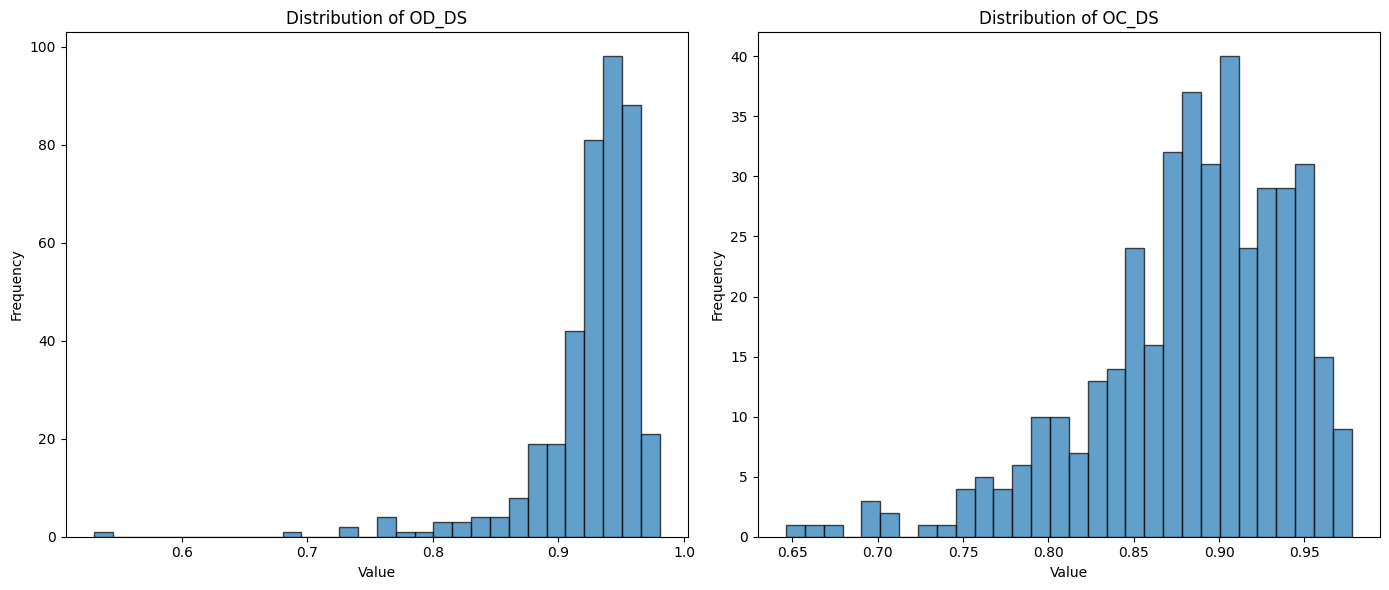

OD Seg Dice Score:  0.9263095259666443 ± 0.04452712833881378
OC Seg Dice Score:  0.8834999203681946 ± 0.05872560665011406
Here are 5 random sample visualisations: 
__________________________________________________
OD Seg Dice Score:  0.929813802242279
OC Seg Dice Score:  0.8782140612602234
(256, 256, 2) (256, 256)
2.0


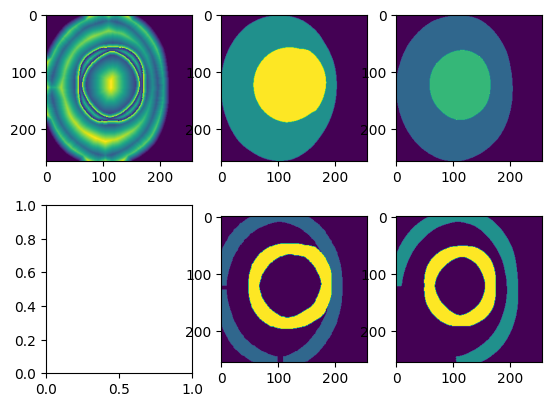

OD Seg Dice Score:  0.8686568737030029
OC Seg Dice Score:  0.9137713313102722
(256, 256, 2) (256, 256)
2.0


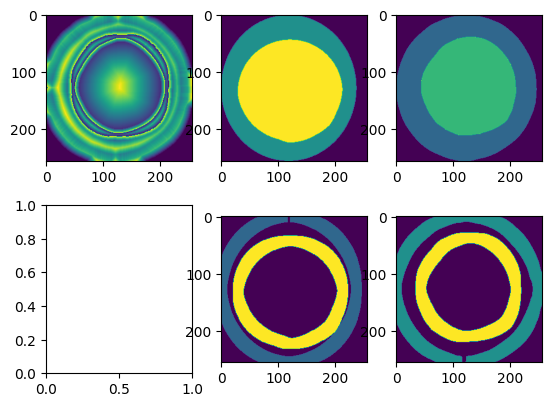

OD Seg Dice Score:  0.943817675113678
OC Seg Dice Score:  0.8770521879196167
(256, 256, 2) (256, 256)
2.0


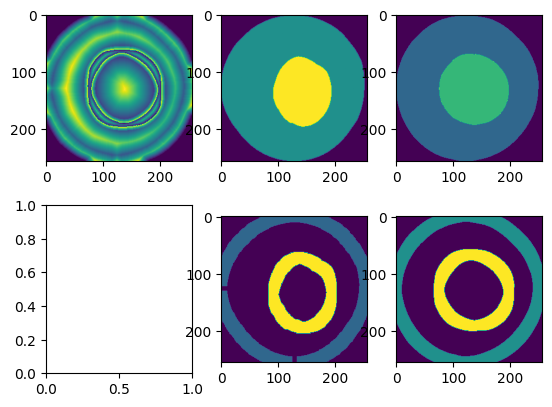

OD Seg Dice Score:  0.9076923131942749
OC Seg Dice Score:  0.9090667963027954
(256, 256, 2) (256, 256)
2.0


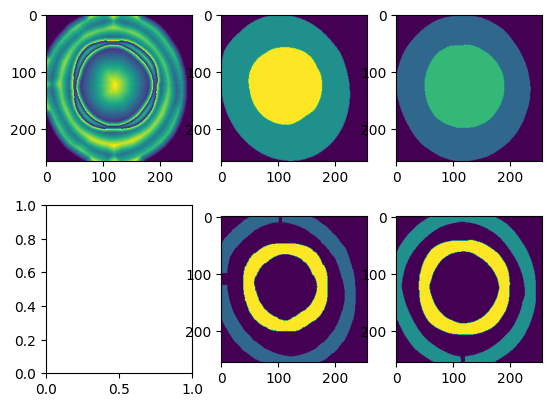

OD Seg Dice Score:  0.9151498079299927
OC Seg Dice Score:  0.8869282603263855
(256, 256, 2) (256, 256)
2.0


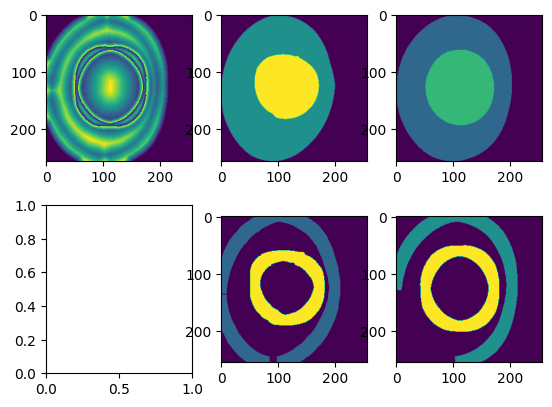

In [50]:
from skimage.transform import resize

# Initialize lists to store dice scores
od_dice_scores = []
oc_dice_scores = []

# Loop through all images to calculate dice scores
for idx in range(len(image_filenames)):
    sample_img, sample_mask, sample_boundary, pred_od, pred_oc, pred_od_bd, pred_oc_bd, gt_od, gt_oc, bd_od, bd_oc, val_mask = get_preds(idx)
    od_dice_scores.append(compute_dice_coef(pred_od, gt_od))
    oc_dice_scores.append(compute_dice_coef(pred_oc, gt_oc))
    
plt.figure(figsize=(14, 6))

# Plot for the first array
plt.subplot(1, 2, 1)
plt.hist(od_dice_scores, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of OD_DS')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot for the second array
plt.subplot(1, 2, 2)
plt.hist(oc_dice_scores, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of OC_DS')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Calculate mean dice scores
mean_od_dice = np.mean(od_dice_scores)
mean_oc_dice = np.mean(oc_dice_scores)
std_od_dice = np.std(od_dice_scores)
std_oc_dice = np.std(oc_dice_scores)
print(f"OD Seg Dice Score:  {mean_od_dice} ± {std_od_dice}")
print(f"OC Seg Dice Score:  {mean_oc_dice} ± {std_oc_dice}")

# Randomly select 5 images for visualization
random_indices = random.sample(range(len(image_filenames)), 5)
print("Here are 5 random sample visualisations: ")
print('_'*50)
# Visualization
for idx in random_indices:
    sample_img, sample_mask, sample_boundary, pred_od, pred_oc, pred_od_bd, pred_oc_bd, gt_od, gt_oc, bd_od, bd_oc, val_mask = get_preds(idx)
    
    f, axarr = plt.subplots(2, 3, squeeze=False)
    print(f"OD Seg Dice Score:  {compute_dice_coef(pred_od, gt_od)}")
    print(f"OC Seg Dice Score:  {compute_dice_coef(pred_oc, gt_oc)}")

    input_img = np.swapaxes(np.swapaxes(sample_img, 0, 2), 0, 1)
    gt_mask = np.swapaxes(np.swapaxes(sample_mask, 0, 2), 0, 1)
    gt_mask[:, :, 0][gt_mask[:, :, 0] > 0] = 2
    output_mask = gt_mask[:, :, 0] + gt_mask[:, :, 1]
    print(gt_mask.shape, output_mask.shape)
    print(np.max(output_mask))
    pred_od_mask = pred_od.numpy().reshape(256, 256) + (2 * pred_oc.numpy().reshape(256, 256))
    bd_mask = bd_od.numpy().reshape(256, 256) + (2 * bd_oc.numpy().reshape(256, 256))
    pred_od_bd_mask = pred_od_bd.numpy().reshape(256, 256) + (2 * pred_oc_bd.numpy().reshape(256, 256))

    axarr[0][0].imshow(input_img)
    axarr[0][1].imshow(val_mask)
    axarr[0][2].imshow(pred_od_mask)
    axarr[1][1].imshow(bd_mask)
    axarr[1][2].imshow(pred_od_bd_mask)
    plt.show()